In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import math
import serial
from threading import Thread
import time
import re

import pylab as pl
from IPython import display
import matplotlib.pyplot as plt

import cv2
import numpy as np
from utils.depth_manager import *
from utils.projections import *
from tqdm import tqdm

In [3]:
%matplotlib qt

In [4]:
# connect to the Serial
SERIAL_CONNECTION = serial.Serial('COM3', 9600)
time.sleep(2)

# Utils

In [5]:
def parse_serial(serial_msg):
    """
    Function to parse serial data to extract float values
    format 'x:19.34 y:23.01 z:-33.83' to x, y, z float values

    Args:
        - (str) string with format 'x:19.34 y:23.01 z:-33.83'
    Return:
        - (list) x, y, z float values
    """
    xyz_list = re.findall('[-+]?[0-9]*\.?[0-9]*', serial_msg)
    return [float(i) for i in filter(lambda item: item, xyz_list)]

In [6]:
def UpdateOrientation(ser):
    """
    Function to integration the x data from the Gyroscope
    and update the global variable x_orientation with the new value

    Args:
        - (serial.Serial) serial to get the gyroscope data
    """
    global X_ORIENTATION

    while True:
        serial_msg_bytes = ser.readline()
        serial_msg = serial_msg_bytes.decode()
        dx, dy, dz = parse_serial(serial_msg)
        
        # The gyroscope values are in degrees-per-second
        # divide each value by the number of samples per second
        dx_normalized = dx / GYROSCOPE_SAMPLE_RATE;

        # remove noise
        if(abs(dx_normalized) > 0.004):
            # update orientation
            X_ORIENTATION = X_ORIENTATION - dx_normalized*1.25
            X_ORIENTATION = X_ORIENTATION%360

# Update orientation in real time

In [7]:
# initialize x orientation
X_ORIENTATION = 0

# 119 got from Arduino with IMU.gyroscopeSampleRate();
GYROSCOPE_SAMPLE_RATE= 119

In [8]:
# run the thread to update the x orientation in real time
Thread(target=UpdateOrientation, args=(SERIAL_CONNECTION,)).start()

# Get depth image and do projection

In [9]:
INTERPRETER = get_tflite_interpreter(
    "https://tfhub.dev/intel/lite-model/midas/v2_1_small/1/lite/1?lite-format=tflite",
    "model/midas_v2_1_small.tflite")

# Calcul projection in real time

In [37]:
IMG_FROM_WEBCAM = True

if IMG_FROM_WEBCAM:
    VID = cv2.VideoCapture(0)
else:
    # Get input image from disk
    IMG = cv2.imread('images/dog.jpg')
    RGB_IMG = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)

FIG_SIMULATION = plt.figure()

POINTS_IN_NED = np.array([])
DEPTH_VALUES = []

PROJECT_DEPTH = True

DEGREES_INTERVAL = 30

ORIENTATIONS_DONE = []
ORIENTATIONS_TODO = [orientation for orientation
                     in range(0, 359, DEGREES_INTERVAL)]

DEPTH_MAP = np.ones((DEPTH_HEIGHT, DEPTH_WIDTH, 1), np.uint8)

MIN_DEPTH_VALUE = 1
MAX_DEPTH_VALUE = 4

OVERLAPS_IMG_DEPTH = {}
CORNERS_DISTANCE = {}

try:
    while True:
        if IMG_FROM_WEBCAM:
            ret, frame = VID.read()
            RGB_IMG = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        DEPTH_MAP, POINTS_IN_NED, DEPTH_VALUES = \
        plot_env(FIG_SIMULATION, X_ORIENTATION, POINTS_IN_NED, DEPTH_VALUES,
                 RGB_IMG, INTERPRETER, PROJECT_DEPTH, ORIENTATIONS_DONE,
                 ORIENTATIONS_TODO, DEPTH_MAP, OVERLAPS_IMG_DEPTH,
                 CORNERS_DISTANCE, pourcentage_to_project=1,
                 min_dist=MIN_DEPTH_VALUE, max_dist=MAX_DEPTH_VALUE)

        # the first depth map was rescale, the next ones will be
        # rescale thank to the previous one to avoid having
        # a discontinuous 3D scene
        if len(ORIENTATIONS_DONE) > 0:
            MIN_DEPTH_VALUE = None
            MAX_DEPTH_VALUE = None

        if len(ORIENTATIONS_TODO) == 0:
            break
except KeyboardInterrupt:
    pass    

plt.show()

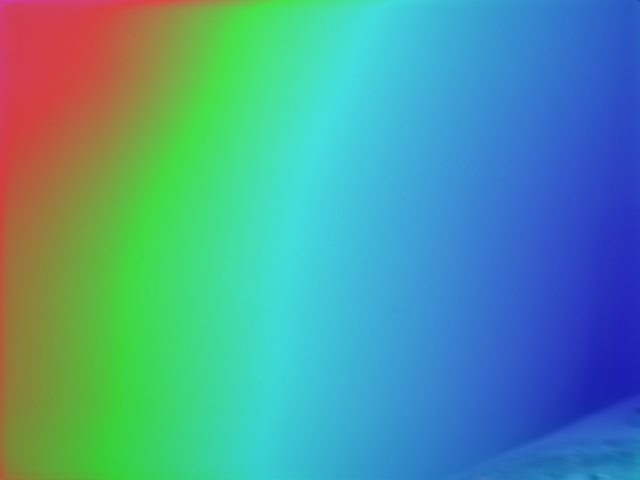

In [76]:
OVERLAPS_IMG_DEPTH[60]

In [39]:
CORNERS_DISTANCE

{270: [array([2.5412953], dtype=float32), array([2.2943933], dtype=float32)],
 300: [array([560.92224], dtype=float32), array([601.5318], dtype=float32)],
 330: [array([66.867516], dtype=float32), array([462.46204], dtype=float32)],
 0: [array([160.27249], dtype=float32), array([188.11992], dtype=float32)],
 30: [array([372.8414], dtype=float32), array([144.75162], dtype=float32)],
 60: [array([1331.7948], dtype=float32), array([225.34723], dtype=float32)],
 90: [array([629.50183], dtype=float32), array([908.29474], dtype=float32)],
 120: [array([276.09885], dtype=float32), array([180.3607], dtype=float32)],
 150: [array([58.212467], dtype=float32), array([509.57782], dtype=float32)],
 180: [array([1117.8302], dtype=float32), array([79.97022], dtype=float32)],
 210: [array([740.5322], dtype=float32), array([106.23188], dtype=float32)],
 240: [array([653.18445], dtype=float32), array([500.4122], dtype=float32)]}